In [1]:
# importing required packages and libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.lines as mlines

In [2]:
pd.set_option("mode.copy_on_write", True)

In [3]:
# loading the dataset and saving in pandas dataframe for easy manipulation
dataset = load_dataset("revanth7667/usa_opioid_overdose")
df = pd.DataFrame(dataset["train"])

In [4]:
df.sample(5)

,State,State_Code,County,County_Code,Year,Population,Deaths,Original,State_Mortality_Rate,County_Mortality_Rate
3058,Colorado,CO,GUNNISON,08051,2003,14273,1,False,0.000080,0.000070
37524,West Virginia,WV,WETZEL,54103,2003,17186,3,False,0.000192,0.000175
3017,Colorado,CO,FREMONT,08043,2014,46185,6,False,0.000133,0.000130
34191,Utah,UT,DAVIS,49011,2005,269208,9,False,0.000040,0.000033
129,Alabama,AL,CHEROKEE,01019,2015,25739,4,False,0.000164,0.000155


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38673 entries, 0 to 38672
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   State                  38673 non-null  object 
 1   State_Code             38673 non-null  object 
 2   County                 38673 non-null  object 
 3   County_Code            38673 non-null  object 
 4   Year                   38673 non-null  int64  
 5   Population             38673 non-null  int64  
 6   Deaths                 38673 non-null  int64  
 7   Original               38673 non-null  bool   
 8   State_Mortality_Rate   38673 non-null  float64
 9   County_Mortality_Rate  38673 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 2.7+ MB


In [6]:
df.describe()

,Year,Population,Deaths,State_Mortality_Rate,County_Mortality_Rate
count,38673.000000,3.867300e+04,38673.000000,38673.000000,38673.000000
mean,2009.085408,1.016857e+05,10.279446,0.000114,0.000087
std,3.735477,3.201735e+05,30.797244,0.000054,0.000079
min,2003.000000,0.000000e+00,0.000000,0.000012,0.000000
25%,2006.000000,1.229900e+04,1.000000,0.000080,0.000043
50%,2009.000000,2.715300e+04,2.000000,0.000101,0.000079
75%,2012.000000,6.946000e+04,9.000000,0.000134,0.000119
max,2015.000000,1.007726e+07,705.000000,0.000465,0.001266


In [7]:
# Mortality Multiplier
mort_mul = 100000
df["County_Mortality_Rate"] = df["County_Mortality_Rate"] * mort_mul

# Global Setting for ylabels so that they are consistent across all plots
ylabels = f"Mortality per {mort_mul:,} Population"

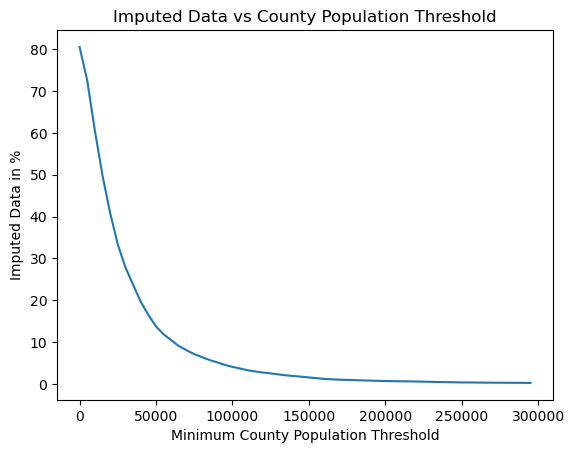

In [8]:
# Creating a plot to see the variation of imputed data with the population of counties
threshold = []
missing = []
for i in range(0, 300000, 5000):
    threshold.append(i)
    missing.append(
        (((df["Population"] >= i) & ~(df["Original"])).sum() / len(df)) * 100
    )

# plotting this
plt.plot(threshold, missing)
plt.xlabel("Minimum County Population Threshold")
plt.ylabel("Imputed Data in %")
plt.title("Imputed Data vs County Population Threshold")

plt.show()

In [9]:
# Subset the dataset for the analysis
def prepare_data(
    dataset, test_state, control_states, policy_year, start_year, end_year
):
    # Filter states
    state_list = [test_state] + control_states
    sub_dataset = dataset[dataset["State_Code"].isin(state_list)]

    # Filter years
    sub_dataset = sub_dataset[
        (sub_dataset["Year"] >= start_year) & (sub_dataset["Year"] <= end_year)
    ]

    # Tagging for pre-post policy implementation and test-control
    sub_dataset["policy_implementation"] = sub_dataset["Year"] >= policy_year
    sub_dataset["State_Type"] = sub_dataset["State_Code"].apply(
        lambda x: "Test" if x == test_state else "Control"
    )

    return sub_dataset

In [10]:
def plot_pre_post_policy_graph(
    dataset_in, test_state, policy_year, metric_column, ax, title=None
):
    # fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe

    sns.regplot(
        data=dataset[
            (dataset["State_Code"] == test_state)
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    sns.regplot(
        data=dataset[
            (dataset["State_Code"] == test_state)
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    ax.axvline(policy_year, ls="--", color="orange")

    ax.legend(
        handles=[
            mlines.Line2D([], [], color="blue", label="Pre-Policy"),
            mlines.Line2D([], [], color="red", label="Post-Policy"),
        ],
        loc="lower right",
    )

    if title:
        ax.set_title(title)
    else:
        ax.set_title(
            f"Pre-Post Policy Implementation Trend for Mortality: {test_state}"
        )
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabels)
    # plt.show()

In [11]:
def plot_diff_in_diff_graph(
    dataset_in, test_state, policy_year, metric_column, ax, title=None
):
    # fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    # Plotting for test state - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for test state - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Adding vertical line for policy year
    ax.axvline(policy_year, ls="--", color="orange")

    # Creating custom legend handles
    blue_line = mlines.Line2D([], [], color="blue", label="Test State")
    red_line = mlines.Line2D([], [], color="red", label="Control States")

    # Adding legends
    ax.legend(handles=[blue_line, red_line], loc="lower right")
    # plt.legend(handles=[blue_line, red_line], loc="lower right")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"Difference-in-Difference Analysis for Mortality: {test_state}")
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabels)

In [12]:
# control Parameters
test_state = "FL"
control_states = ["GA", "SC", "AL"]
policy_year = 2010
start_year = 2003
end_year = 2017

In [13]:
dataset_original = prepare_data(
    df[df["Original"] == True],
    test_state,
    control_states,
    policy_year,
    start_year,
    end_year,
)

dataset_imputed = prepare_data(
    df, test_state, control_states, policy_year, start_year, end_year
)

dataset_filtered = dataset = prepare_data(
    df[df["Population"] >= 50000],
    test_state,
    control_states,
    policy_year,
    start_year,
    end_year,
)

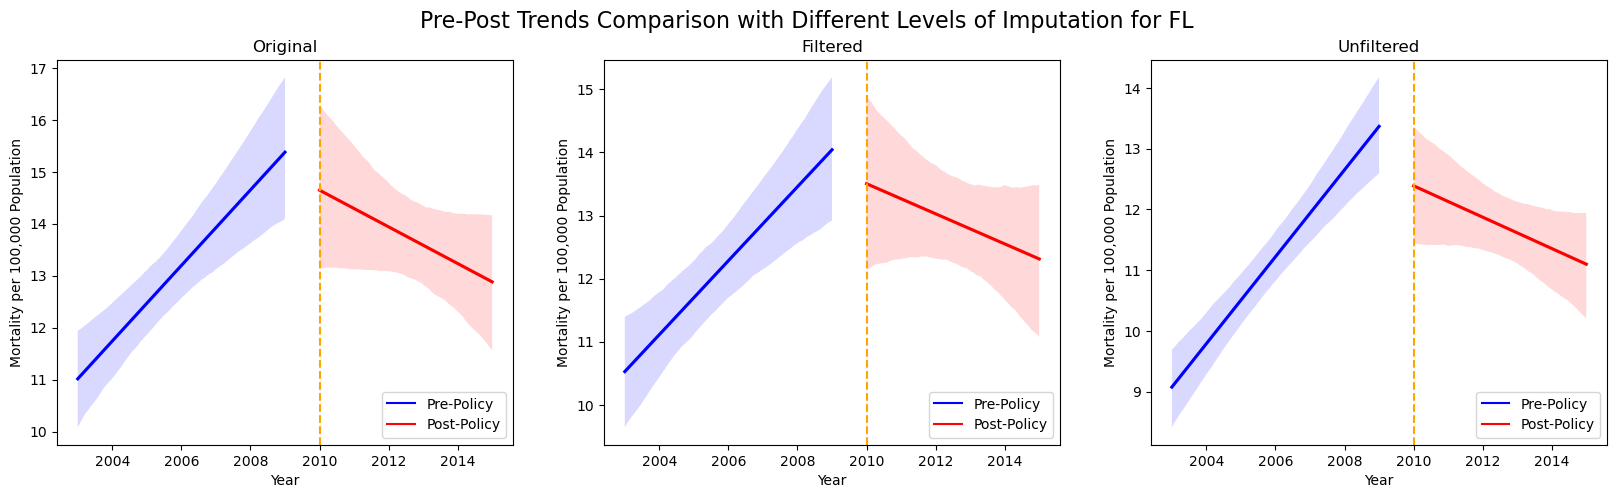

In [14]:
# plot the below graohs in a single row

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Using the original dataset
plot_pre_post_policy_graph(
    dataset_original,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[0],
    "Original",
)

# using 50000 as population threshold
plot_pre_post_policy_graph(
    dataset_filtered,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[1],
    "Filtered",
)

# Using the imputed dataset
plot_pre_post_policy_graph(
    dataset_imputed,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[2],
    "Unfiltered",
)


# master title
fig.suptitle(
    f"Pre-Post Trends Comparison with Different Levels of Imputation for {test_state}",
    fontsize=16,
)
plt.show()

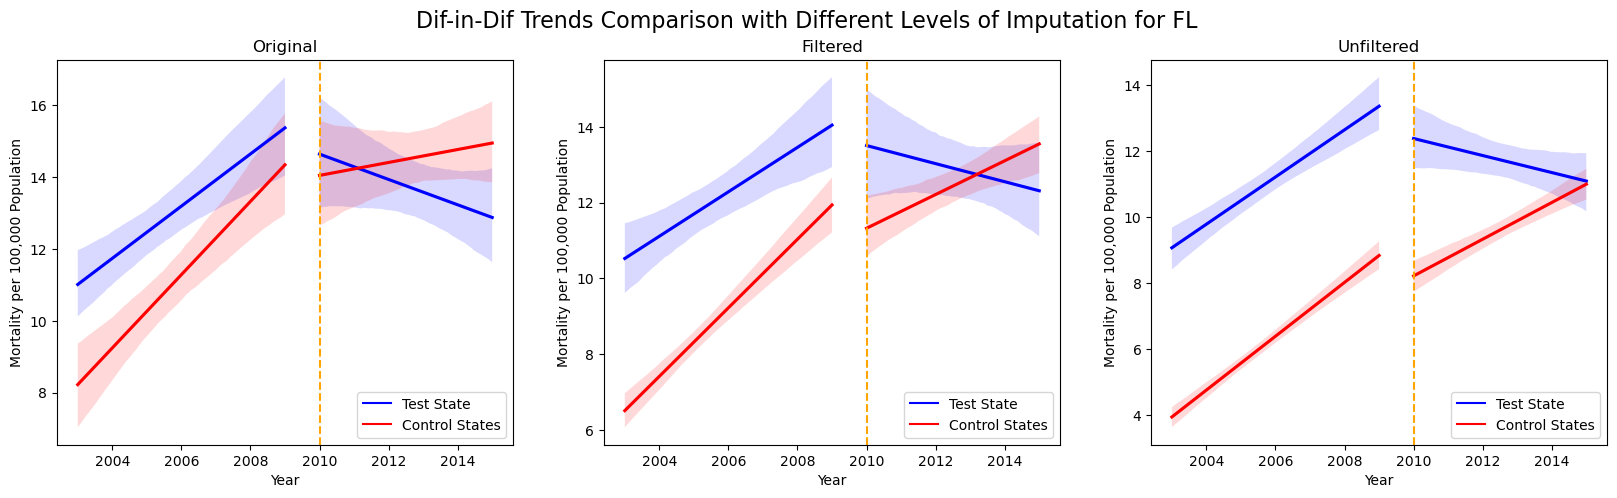

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))


plot_diff_in_diff_graph(
    dataset_original,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[0],
    "Original",
)
plot_diff_in_diff_graph(
    dataset_filtered,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[1],
    "Filtered",
)
plot_diff_in_diff_graph(
    dataset_imputed,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[2],
    "Unfiltered",
)

# master title
fig.suptitle(
    f"Dif-in-Dif Trends Comparison with Different Levels of Imputation for {test_state}",
    fontsize=16,
)
plt.show()

In [16]:
# control Parameters
test_state = "TX"
control_states = ["OK", "NM", "LA"]
policy_year = 2007
start_year = 2003
end_year = 2011

In [17]:
dataset_original = prepare_data(
    df[df["Original"] == True],
    test_state,
    control_states,
    policy_year,
    start_year,
    end_year,
)

dataset_imputed = prepare_data(
    df, test_state, control_states, policy_year, start_year, end_year
)

dataset_filtered = dataset = prepare_data(
    df[df["Population"] >= 50000],
    test_state,
    control_states,
    policy_year,
    start_year,
    end_year,
)

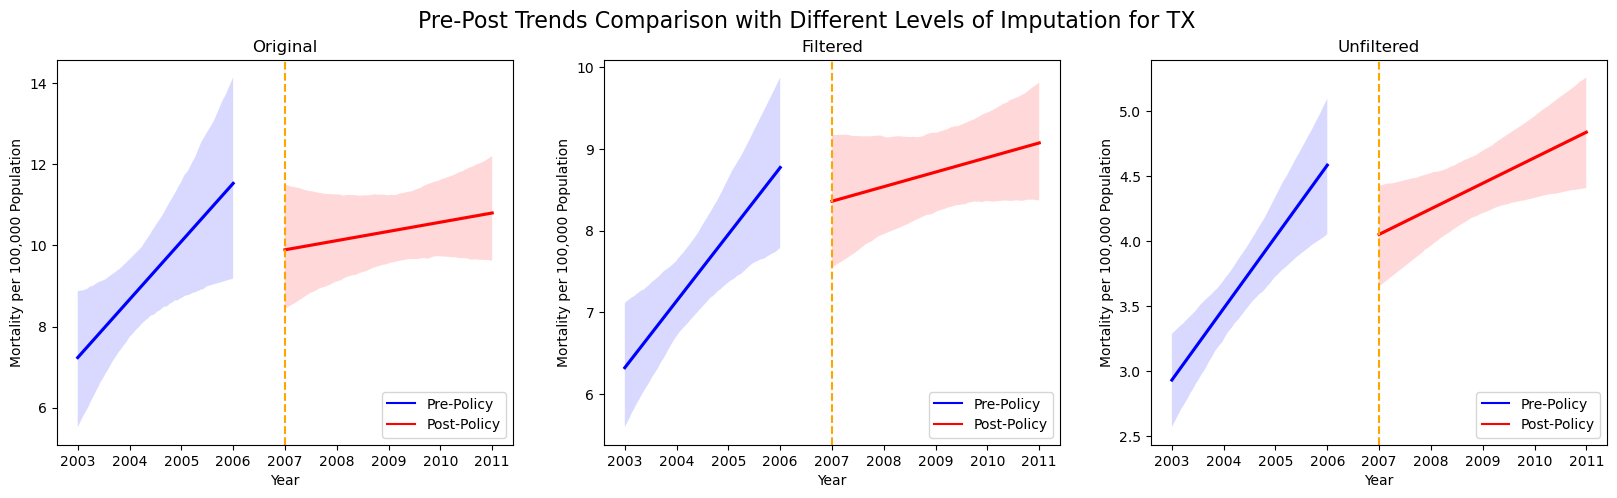

In [18]:
# plot the below graohs in a single row

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Using the original dataset
plot_pre_post_policy_graph(
    dataset_original,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[0],
    "Original",
)

# using 50000 as population threshold
plot_pre_post_policy_graph(
    dataset_filtered,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[1],
    "Filtered",
)

# Using the imputed dataset
plot_pre_post_policy_graph(
    dataset_imputed,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[2],
    "Unfiltered",
)


# master title
fig.suptitle(
    f"Pre-Post Trends Comparison with Different Levels of Imputation for {test_state}",
    fontsize=16,
)
plt.show()

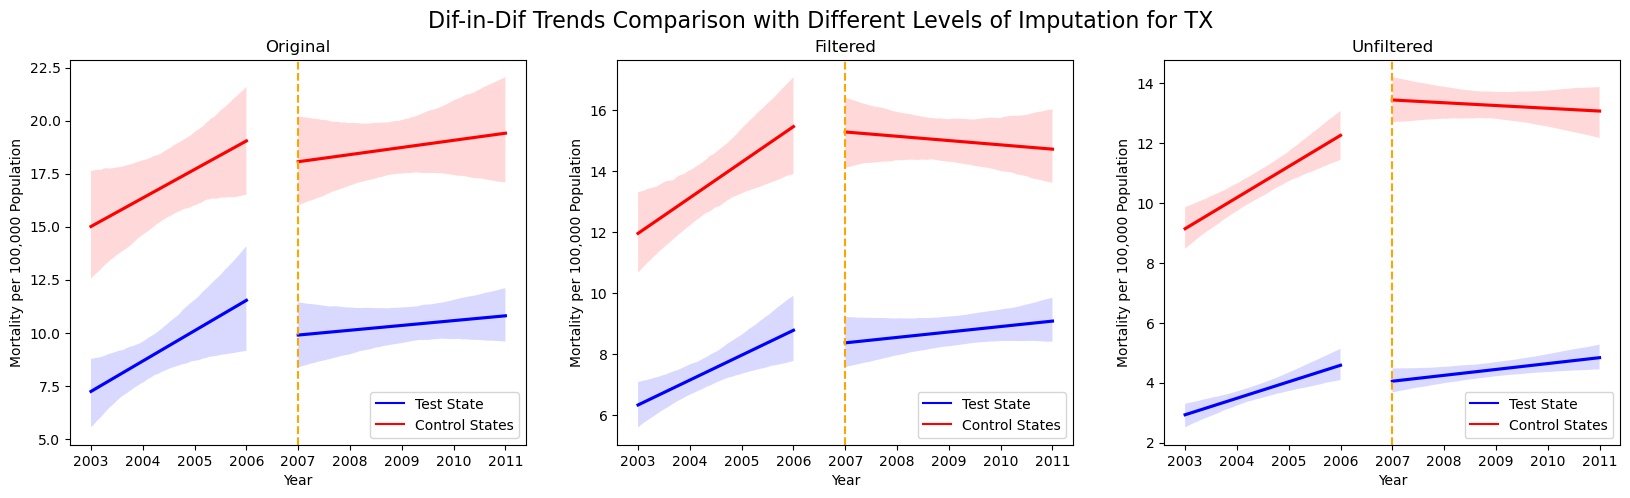

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))


plot_diff_in_diff_graph(
    dataset_original,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[0],
    "Original",
)
plot_diff_in_diff_graph(
    dataset_filtered,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[1],
    "Filtered",
)
plot_diff_in_diff_graph(
    dataset_imputed,
    test_state,
    policy_year,
    "County_Mortality_Rate",
    ax[2],
    "Unfiltered",
)

# master title
fig.suptitle(
    f"Dif-in-Dif Trends Comparison with Different Levels of Imputation for {test_state}",
    fontsize=16,
)
plt.show()

In [20]:
# Total Number of State-Counties in the dataset
df["County_Code"].nunique()

3115

In [21]:
df[df["Original"] == True]["County_Code"].nunique()

1018